In [1]:
# Utility imports
from os import listdir
import os
import random
import imageio
import skimage
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt

# Mask RCNN imports
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

# Keras imports
import keras
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)          # limit GPU memory

keras.backend.clear_session()                   # disallocate GPU memory

#print(tf.__version__)

In [2]:
print(keras.__version__)

2.6.0


In [3]:
# class that defines and loads the firearm dataset
class FirearmsDataset(utils.Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir):
        # define classes
        self.add_class("dataset", 1, "Gun")
        #self.add_class("dataset", 2, "Rifle")
        # define data locations
        images_dir = dataset_dir
        annotations_dir = 'FDNS/YTGDD/annotations/'
             
            
		# find all images
        for filename in listdir(images_dir):
            #print(filename)
			# extract image id
            image_id = filename[:-4]
			#print('IMAGE ID: ',image_id)
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids = [0,1,2])


	# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
		# load and parse the file
        tree = ElementTree.parse(filename)
		# get the root of the document
        root = tree.getroot()
		# extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text   #Add label name to the box list
            xmin = int(float(box.find('./bndbox/xmin').text))
            ymin = int(float(box.find('./bndbox/ymin').text))
            xmax = int(float(box.find('./bndbox/xmax').text))
            ymax = int(float(box.find('./bndbox/ymax').text))
            coors = [xmin, ymin, xmax, ymax, name]
            
            boxes.append(coors)
		# extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    
	# load the masks for an image
    def load_mask(self, image_id):
		# get details of image
        info = self.image_info[image_id]
		# define box file location
        path = info['annotation']
        #return info, path
        
        
		# load XML
        boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            
            
            # box[4] will have the name of the class 
            if (box[4] == 'Gun'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Gun'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Rifle')) 
          
        return masks, asarray(class_ids, dtype='int32')
        

	# load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [4]:
images_dir='FDNS/YTGDD/images/'

# Destination folders
train_dir = images_dir + 'train/'
val_dir = images_dir + 'validation/'
test_dir = images_dir + 'test/'

In [5]:
# training set
train_set = FirearmsDataset()
train_set.load_dataset(train_dir)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# validation set
val_set = FirearmsDataset()
val_set.load_dataset(val_dir)
val_set.prepare()
print('Validation: %d' % len(val_set.image_ids))

# test set
test_set = FirearmsDataset()
test_set.load_dataset(test_dir)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 2391
Validation: 299
Test: 298


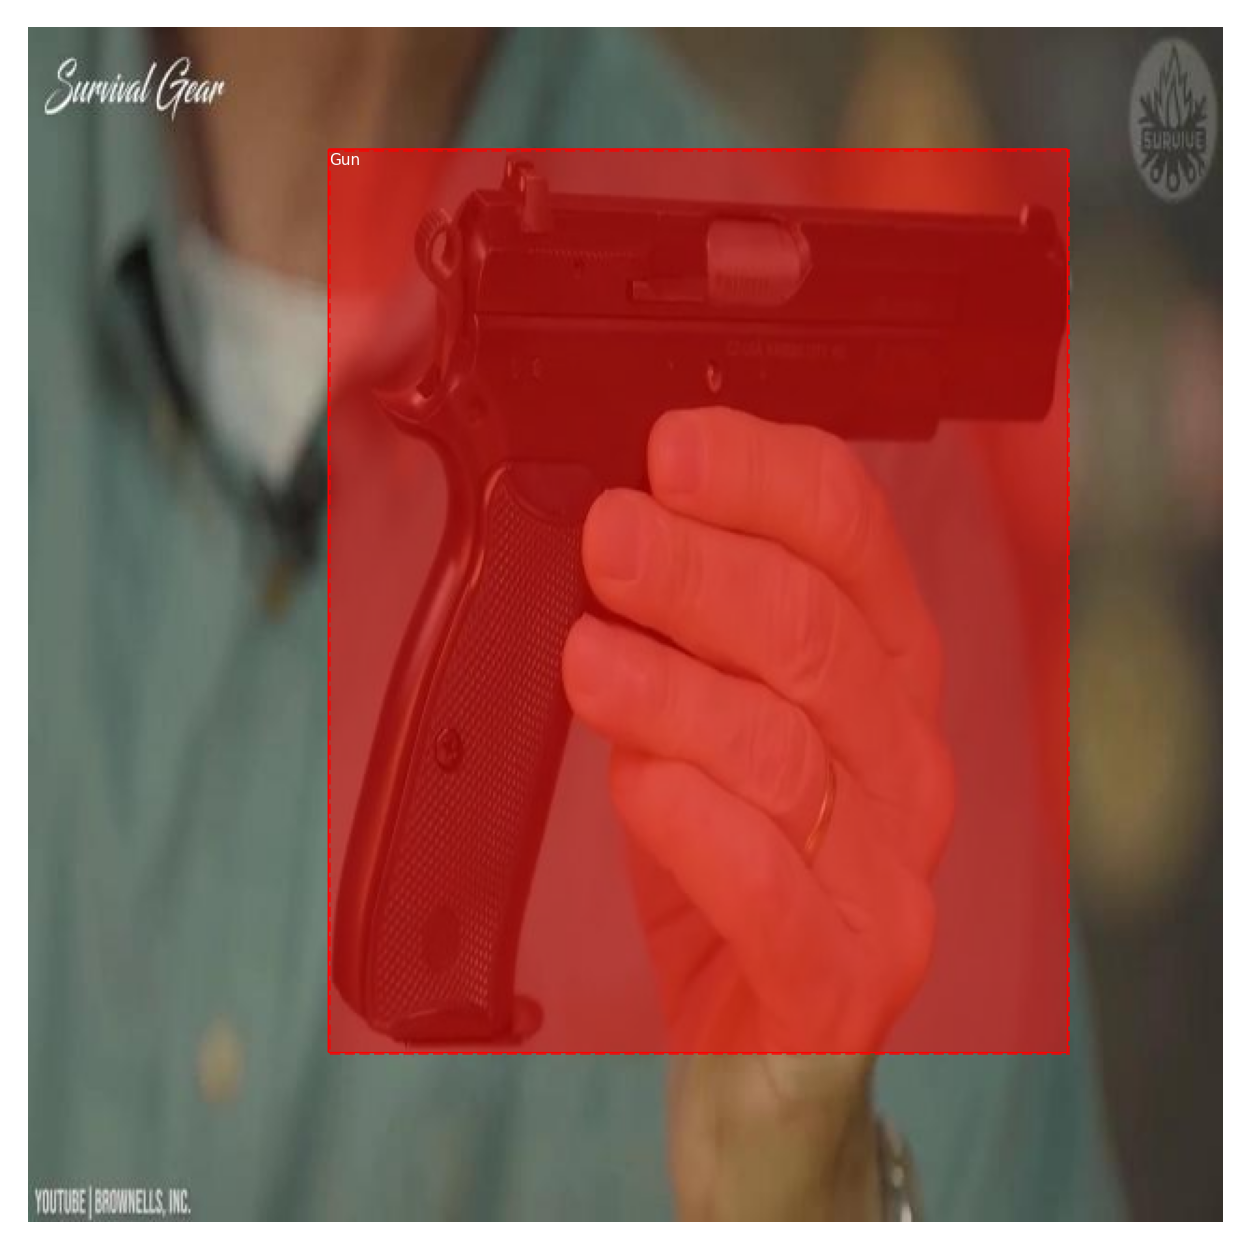

In [6]:
num=random.randint(0, len(train_set.image_ids))
# define image id
image_id = num
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = utils.extract_bboxes(mask)
# display image with masks and bounding boxes
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [7]:
# define a configuration for the model
class FirearmsConfig(Config):
	# define the name of the configuration
	NAME = "firearms_cfg"
	# number of classes (background + 2 detected classes (Handgun + Rifle))
#NUM_CLASSES = 1 + 2
	NUM_CLASSES = 1 + 1   # Background + Handgun
	USE_MINI_MASK = False
	# number of training steps per epoch
	STEPS_PER_EPOCH = 100
	IMAGES_PER_GPU = 1
	RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
	MAX_GT_INSTANCES = 1
	DETECTION_MAX_INSTANCES = 1
	DETECTION_MIN_CONFIDENCE = 0.9
	BACKBONE = "resnet101"
	VALIDATION_STEPS = 100

In [8]:
# prepare config
config = FirearmsConfig()
config.display()

ROOT_DIR = os.path.abspath("./")
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
print(ROOT_DIR)
print(DEFAULT_LOGS_DIR)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     512
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [9]:
keras.backend.clear_session()                # disallocate GPU memory
# define the model
model = modellib.MaskRCNN(mode='training', model_dir="logs", config=config)
# Set early stopping after certain number of epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# load weights (mscoco) and exclude the output layers
#model.load_weights("mask_rcnn_coco/mask_rcnn_coco.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
#model.load_weights("FDNS/weights/fdns_mask_rcnn_101_YTGDD.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# train weights (output layers or 'heads')
# model.train(train_set, 
#             val_set, 
#             learning_rate=0.001, 
#             epochs=100,
#             custom_callbacks=[callback],
#             layers='heads')

model.train(train_set, 
            val_set, 
            learning_rate=0.01, 
            epochs=1000,
            custom_callbacks=[callback],
            layers='all')


Starting at epoch 0. LR=0.01

Checkpoint Path: logs/firearms_cfg20230307T0358/mask_rcnn_firearms_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b        

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", shape=(Non

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 4.0519 - rpn_class_loss: 0.2657 - rpn_bbox_loss: 2.1535 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 1.0184 - mrcnn_mask_loss: 0.4680

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


100/100 [==============================] - 57s 424ms/step - batch: 49.5000 - size: 1.0000 - loss: 4.0519 - rpn_class_loss: 0.2657 - rpn_bbox_loss: 2.1535 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 1.0184 - mrcnn_mask_loss: 0.4680 - val_loss: 2.2885 - val_rpn_class_loss: 0.1260 - val_rpn_bbox_loss: 0.7081 - val_mrcnn_class_loss: 0.0667 - val_mrcnn_bbox_loss: 0.8894 - val_mrcnn_mask_loss: 0.4982
Epoch 2/1000
100/100 [==============================] - 22s 219ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.8787 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.5738 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.6845 - mrcnn_mask_loss: 0.4680 - val_loss: 1.6476 - val_rpn_class_loss: 0.0793 - val_rpn_bbox_loss: 0.5605 - val_mrcnn_class_loss: 0.0597 - val_mrcnn_bbox_loss: 0.5534 - val_mrcnn_mask_loss: 0.3947
Epoch 3/1000
100/100 [==============================] - 22s 222ms/step - batch: 49.5000 - size: 1.0000 - loss: 2.1855 - rpn_class_loss: 0.0972 - rpn_bbox_loss: 0.6524 - mrcnn_class_loss: 

Epoch 21/1000
100/100 [==============================] - 22s 223ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.4812 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.5094 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.5092 - mrcnn_mask_loss: 0.3546 - val_loss: 1.5515 - val_rpn_class_loss: 0.0723 - val_rpn_bbox_loss: 0.5298 - val_mrcnn_class_loss: 0.0401 - val_mrcnn_bbox_loss: 0.5289 - val_mrcnn_mask_loss: 0.3804
Epoch 22/1000
100/100 [==============================] - 22s 222ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.4128 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.4446 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.3744 - val_loss: 1.4180 - val_rpn_class_loss: 0.0602 - val_rpn_bbox_loss: 0.4659 - val_mrcnn_class_loss: 0.0341 - val_mrcnn_bbox_loss: 0.5013 - val_mrcnn_mask_loss: 0.3564
Epoch 23/1000
100/100 [==============================] - 22s 221ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.4317 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 0.4817 - mr

Epoch 41/1000
100/100 [==============================] - 22s 221ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.2304 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.4025 - mrcnn_mask_loss: 0.3147 - val_loss: 1.3532 - val_rpn_class_loss: 0.0646 - val_rpn_bbox_loss: 0.4939 - val_mrcnn_class_loss: 0.0286 - val_mrcnn_bbox_loss: 0.4222 - val_mrcnn_mask_loss: 0.3438
Epoch 42/1000
100/100 [==============================] - 22s 221ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.2789 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 0.5220 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.3709 - mrcnn_mask_loss: 0.2787 - val_loss: 1.3082 - val_rpn_class_loss: 0.0760 - val_rpn_bbox_loss: 0.4202 - val_mrcnn_class_loss: 0.0239 - val_mrcnn_bbox_loss: 0.4361 - val_mrcnn_mask_loss: 0.3519
Epoch 43/1000
100/100 [==============================] - 22s 222ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.2518 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.4670 - mr

In [10]:
model.keras_model.save_weights('FDNS/weights/fdns_mask_rcnn_101_YTGDD.h5')

In [11]:
model.keras_model.summary()
#model.keras_model.history.history

Model: "mask_rcnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_image[0][0]']            
                                3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9472        ['zero_padding2d[0][0]']         
                                64)                                                       

                                                                                                  
 res2b_out (Activation)         (None, None, None,   0           ['add_1[0][0]']                  
                                256)                                                              
                                                                                                  
 res2c_branch2a (Conv2D)        (None, None, None,   16448       ['res2b_out[0][0]']              
                                64)                                                               
                                                                                                  
 bn2c_branch2a (BatchNorm)      (None, None, None,   256         ['res2c_branch2a[0][0]']         
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 activation_10 (Activation)     (None, None, None,   0           ['bn3b_branch2b[0][0]']          
                                128)                                                              
                                                                                                  
 res3b_branch2c (Conv2D)        (None, None, None,   66048       ['activation_10[0][0]']          
                                512)                                                              
                                                                                                  
 bn3b_branch2c (BatchNorm)      (None, None, None,   2048        ['res3b_branch2c[0][0]']         
                                512)                                                              
          

 activation_15 (Activation)     (None, None, None,   0           ['bn4a_branch2a[0][0]']          
                                256)                                                              
                                                                                                  
 res4a_branch2b (Conv2D)        (None, None, None,   590080      ['activation_15[0][0]']          
                                256)                                                              
                                                                                                  
 bn4a_branch2b (BatchNorm)      (None, None, None,   1024        ['res4a_branch2b[0][0]']         
                                256)                                                              
                                                                                                  
 activation_16 (Activation)     (None, None, None,   0           ['bn4a_branch2b[0][0]']          
          

                                                                                                  
 add_9 (Add)                    (None, None, None,   0           ['bn4c_branch2c[0][0]',          
                                1024)                             'res4b_out[0][0]']              
                                                                                                  
 res4c_out (Activation)         (None, None, None,   0           ['add_9[0][0]']                  
                                1024)                                                             
                                                                                                  
 res4d_branch2a (Conv2D)        (None, None, None,   262400      ['res4c_out[0][0]']              
                                256)                                                              
                                                                                                  
 bn4d_bran

                                256)                                                              
                                                                                                  
 res4f_branch2c (Conv2D)        (None, None, None,   263168      ['activation_26[0][0]']          
                                1024)                                                             
                                                                                                  
 bn4f_branch2c (BatchNorm)      (None, None, None,   4096        ['res4f_branch2c[0][0]']         
                                1024)                                                             
                                                                                                  
 add_12 (Add)                   (None, None, None,   0           ['bn4f_branch2c[0][0]',          
                                1024)                             'res4e_out[0][0]']              
          

 res4i_branch2b (Conv2D)        (None, None, None,   590080      ['activation_31[0][0]']          
                                256)                                                              
                                                                                                  
 bn4i_branch2b (BatchNorm)      (None, None, None,   1024        ['res4i_branch2b[0][0]']         
                                256)                                                              
                                                                                                  
 activation_32 (Activation)     (None, None, None,   0           ['bn4i_branch2b[0][0]']          
                                256)                                                              
                                                                                                  
 res4i_branch2c (Conv2D)        (None, None, None,   263168      ['activation_32[0][0]']          
          

                                                                                                  
 bn4l_branch2a (BatchNorm)      (None, None, None,   1024        ['res4l_branch2a[0][0]']         
                                256)                                                              
                                                                                                  
 activation_37 (Activation)     (None, None, None,   0           ['bn4l_branch2a[0][0]']          
                                256)                                                              
                                                                                                  
 res4l_branch2b (Conv2D)        (None, None, None,   590080      ['activation_37[0][0]']          
                                256)                                                              
                                                                                                  
 bn4l_bran

                                1024)                             'res4m_out[0][0]']              
                                                                                                  
 res4n_out (Activation)         (None, None, None,   0           ['add_20[0][0]']                 
                                1024)                                                             
                                                                                                  
 res4o_branch2a (Conv2D)        (None, None, None,   262400      ['res4n_out[0][0]']              
                                256)                                                              
                                                                                                  
 bn4o_branch2a (BatchNorm)      (None, None, None,   1024        ['res4o_branch2a[0][0]']         
                                256)                                                              
          

 res4q_branch2c (Conv2D)        (None, None, None,   263168      ['activation_48[0][0]']          
                                1024)                                                             
                                                                                                  
 bn4q_branch2c (BatchNorm)      (None, None, None,   4096        ['res4q_branch2c[0][0]']         
                                1024)                                                             
                                                                                                  
 add_23 (Add)                   (None, None, None,   0           ['bn4q_branch2c[0][0]',          
                                1024)                             'res4p_out[0][0]']              
                                                                                                  
 res4q_out (Activation)         (None, None, None,   0           ['add_23[0][0]']                 
          

                                                                                                  
 bn4t_branch2b (BatchNorm)      (None, None, None,   1024        ['res4t_branch2b[0][0]']         
                                256)                                                              
                                                                                                  
 activation_54 (Activation)     (None, None, None,   0           ['bn4t_branch2b[0][0]']          
                                256)                                                              
                                                                                                  
 res4t_branch2c (Conv2D)        (None, None, None,   263168      ['activation_54[0][0]']          
                                1024)                                                             
                                                                                                  
 bn4t_bran

                                256)                                                              
                                                                                                  
 activation_59 (Activation)     (None, None, None,   0           ['bn4w_branch2a[0][0]']          
                                256)                                                              
                                                                                                  
 res4w_branch2b (Conv2D)        (None, None, None,   590080      ['activation_59[0][0]']          
                                256)                                                              
                                                                                                  
 bn4w_branch2b (BatchNorm)      (None, None, None,   1024        ['res4w_branch2b[0][0]']         
                                256)                                                              
          

 bn5b_branch2c (BatchNorm)      (None, None, None,   8192        ['res5b_branch2c[0][0]']         
                                2048)                                                             
                                                                                                  
 add_31 (Add)                   (None, None, None,   0           ['bn5b_branch2c[0][0]',          
                                2048)                             'res5a_out[0][0]']              
                                                                                                  
 res5b_out (Activation)         (None, None, None,   0           ['add_31[0][0]']                 
                                2048)                                                             
                                                                                                  
 res5c_branch2a (Conv2D)        (None, None, None,   1049088     ['res5b_out[0][0]']              
          

                                                                                                  
 rpn_model (Functional)         [(None, None, 2),    1189394     ['fpn_p2[0][0]',                 
                                 (None, None, 2),                 'fpn_p3[0][0]',                 
                                 (None, None, 4)]                 'fpn_p4[0][0]',                 
                                                                  'fpn_p5[0][0]',                 
                                                                  'fpn_p6[0][0]']                 
                                                                                                  
 rpn_class (Concatenate)        (None, None, 2)      0           ['rpn_model[0][1]',              
                                                                  'rpn_model[1][1]',              
                                                                  'rpn_model[2][1]',              
          

 activation_67 (Activation)     (1, None, 1, 1, 102  0           ['mrcnn_class_bn1[0][0]']        
                                4)                                                                
                                                                                                  
 mrcnn_mask_bn3 (TimeDistribute  (1, None, 14, 14, 2  1024       ['mrcnn_mask_conv3[0][0]']       
 d)                             56)                                                               
                                                                                                  
 mrcnn_class_conv2 (TimeDistrib  (1, None, 1, 1, 102  1049600    ['activation_67[0][0]']          
 uted)                          4)                                                                
                                                                                                  
 activation_72 (Activation)     (1, None, 14, 14, 2  0           ['mrcnn_mask_bn3[0][0]']         
          

                                                                                                  
 add_loss (AddLoss)             ()                   0           ['tf_op_layer_mul[0][0]']        
                                                                                                  
 tf_op_layer_Mean_1 (TensorFlow  [()]                0           ['rpn_bbox_loss[0][0]']          
 OpLayer)                                                                                         
                                                                                                  
 tf_op_layer_mul_1 (TensorFlowO  [()]                0           ['tf_op_layer_Mean_1[0][0]']     
 pLayer)                                                                                          
                                                                                                  
 add_loss_1 (AddLoss)           ()                   0           ['tf_op_layer_mul_1[0][0]']      
          

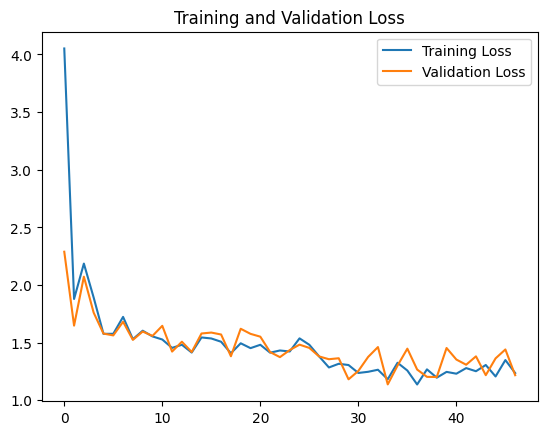

In [11]:
loss = model.keras_model.history.history['loss']
val_loss = model.keras_model.history.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(0,47)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
from matplotlib.patches import Rectangle

# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "firearms_cfg"
	# number of classes (background + 2 detected classes (handgun + rifle))
	NUM_CLASSES = 1 + 1   # Background + Gun
	USE_MINI_MASK = False
	# number of training steps per epoch
	STEPS_PER_EPOCH = 100
	IMAGES_PER_GPU = 1
	RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
	MAX_GT_INSTANCES = 1
	DETECTION_MAX_INSTANCES = 1
	DETECTION_MIN_CONFIDENCE = 0.9
	BACKBONE = "resnet101"
	VALIDATION_STEPS = 100

predcfg = PredictionConfig()
predcfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     512
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [13]:
# Load model in inference mode
keras.backend.clear_session()                # disallocate GPU memory

DEVICE = "/gpu:0"
TEST_MODE = "inference"

with tf.device(DEVICE):
    inf_mod = modellib.MaskRCNN(mode="inference", model_dir='FDNS/weights/', config=predcfg)
    
# Load weights
inf_mod.load_weights('FDNS/weights/fdns_mask_rcnn_101_YTGDD.h5', by_name=True)

Instructions for updating:
Use fn_output_signature instead


In [14]:
dataset = test_set

In [15]:


def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



image ID: dataset.0000002422_jpg.rf.f0c90ad372825484c0e57ddb1bc6706b (79) FDNS/YTGDD/images/test/0000002422_jpg.rf.f0c90ad372825484c0e57ddb1bc6706b.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


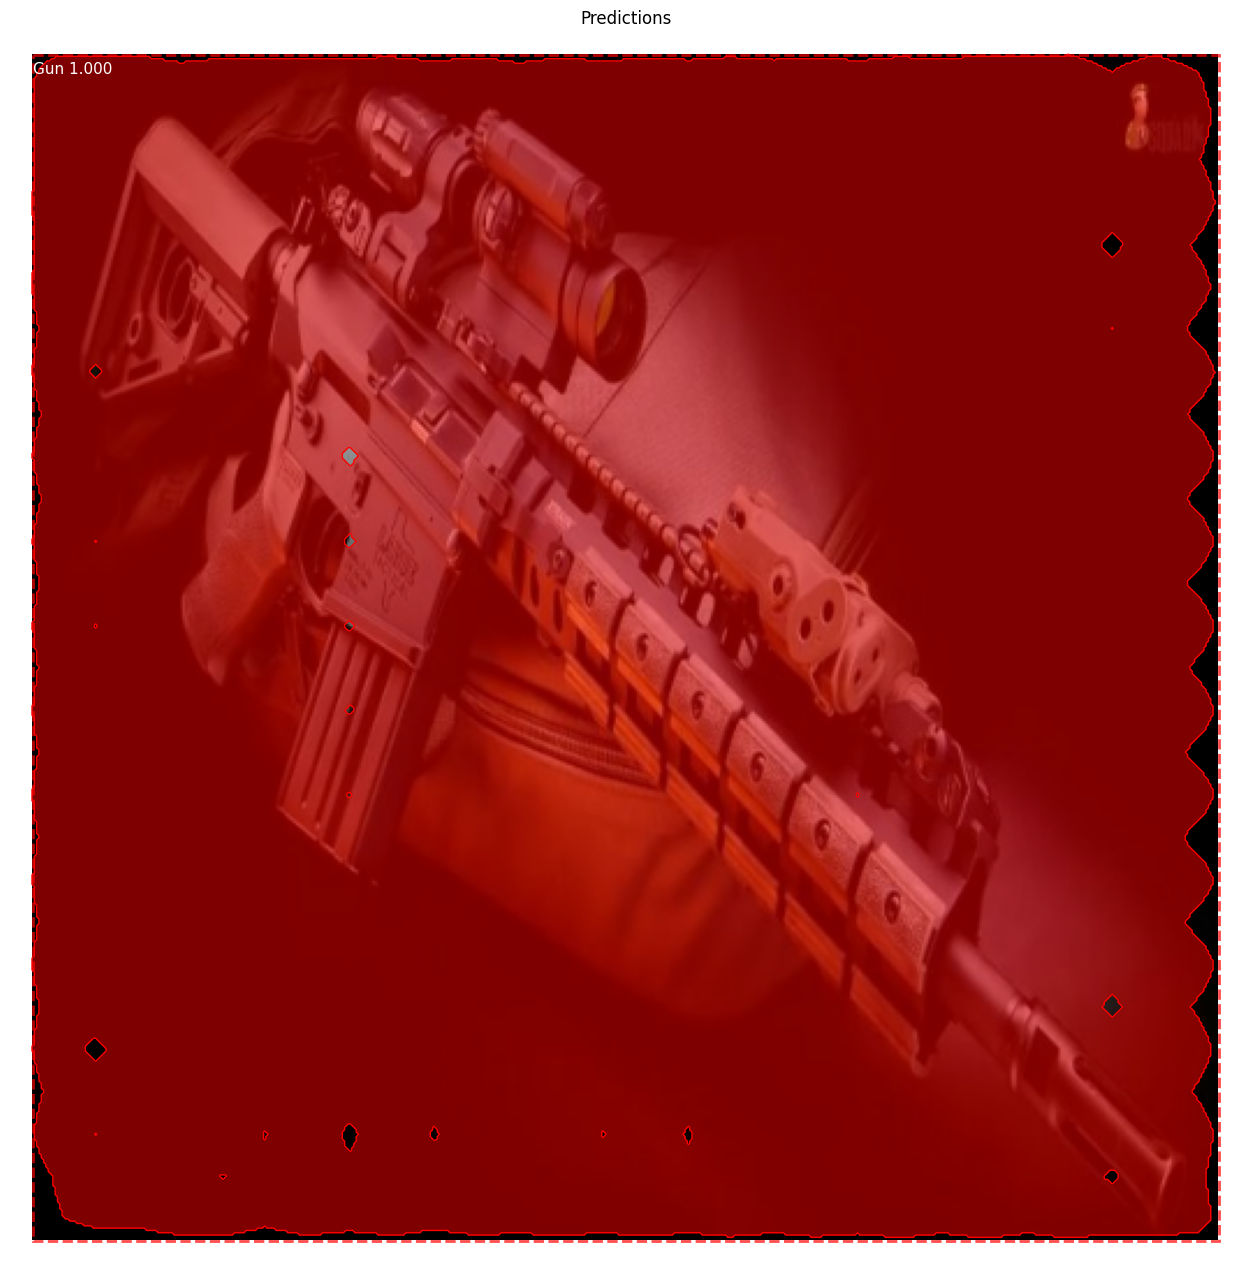

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   20.00000  max:  386.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  uint8


In [53]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = inf_mod.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
plt.show()
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


In [14]:


def run_detection(image_id, model, dataset, verbose=True):
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)
    info = dataset.image_info[image_id]
    if verbose:
        print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           dataset.image_reference(image_id)))
    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    ax = get_ax(1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax,
                                title="Predictions")
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

run_detection(image_id, inf_mod, dataset)



image ID: dataset.d3f70815-corrected-Sig-Sauer-M17-27 (13) FDNS/sigm17/images/validation/d3f70815-corrected-Sig-Sauer-M17-27.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  307.00000  max:  785.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


In [23]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids, model, iou = 0.5, verbose = True):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        try:
            AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'], iou)
        except ValueError:
            AP = 0.00
        APs.append(AP)
        info = dataset.image_info[image_id]
        meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
        if verbose:
            print("{:3} {}   AP: {:.2f}".format(
            meta["image_id"][0], meta["original_image_shape"][0], AP))

    return APs

# Pick a set of random images
image_ids = dataset.image_ids
APs = compute_batch_ap(image_ids, inf_mod)
print("mAP @ IoU=50: ", np.mean(APs))


  0 [640 640   3]   AP: 0.00
  1 [640 640   3]   AP: 0.00
  2 [640 640   3]   AP: 0.00
  3 [640 640   3]   AP: 0.00
  4 [640 640   3]   AP: 0.00
  5 [640 640   3]   AP: 0.00
  6 [640 640   3]   AP: 0.00
  7 [640 640   3]   AP: 0.00
  8 [640 640   3]   AP: 0.00
  9 [640 640   3]   AP: 0.00
 10 [640 640   3]   AP: 0.00
 11 [640 640   3]   AP: 0.00
 12 [640 640   3]   AP: 1.00
 13 [640 640   3]   AP: 0.00
 14 [640 640   3]   AP: 0.00
 15 [640 640   3]   AP: 0.00
 16 [640 640   3]   AP: 0.00
 17 [640 640   3]   AP: 0.00
 18 [640 640   3]   AP: nan
 19 [640 640   3]   AP: 0.00
 20 [640 640   3]   AP: 0.00
 21 [640 640   3]   AP: 0.00
 22 [640 640   3]   AP: 0.00
 23 [640 640   3]   AP: 0.00
 24 [640 640   3]   AP: 0.00
 25 [640 640   3]   AP: 0.00
 26 [640 640   3]   AP: 0.00
 27 [640 640   3]   AP: 0.00
 28 [640 640   3]   AP: 0.00
 29 [640 640   3]   AP: 0.00
 30 [640 640   3]   AP: 0.00
 31 [640 640   3]   AP: 0.00
 32 [640 640   3]   AP: 1.00
 33 [640 640   3]   AP: 0.00
 34 [640 640   

283 [640 640   3]   AP: 0.00
284 [640 640   3]   AP: 0.00
285 [640 640   3]   AP: 0.00
286 [640 640   3]   AP: 0.00
287 [640 640   3]   AP: 0.00
288 [640 640   3]   AP: 0.00
289 [640 640   3]   AP: 0.00
290 [640 640   3]   AP: 0.00
291 [640 640   3]   AP: 0.00
292 [640 640   3]   AP: 0.00
293 [640 640   3]   AP: 0.00
294 [640 640   3]   AP: 0.00
295 [640 640   3]   AP: 0.00
296 [640 640   3]   AP: 0.00
297 [640 640   3]   AP: 0.00
mAP @ IoU=50:  nan


In [24]:
APs = compute_batch_ap(image_ids, inf_mod, 0.25, False)
print("mAP @ IoU=25: ", np.mean(APs))
APs = compute_batch_ap(image_ids, inf_mod, 0.5, False)
print("mAP @ IoU=50: ", np.mean(APs))
APs = compute_batch_ap(image_ids, inf_mod, 0.75, False)
print("mAP @ IoU=75: ", np.mean(APs))
APs = compute_batch_ap(image_ids, inf_mod, 0.9, False)
print("mAP @ IoU=90: ", np.mean(APs))



mAP @ IoU=25:  nan
mAP @ IoU=50:  nan
mAP @ IoU=75:  nan
mAP @ IoU=90:  nan
